In [2]:
# import standard libraries
import numpy as np
import pandas as pd

# import helper functions
import helper as hp
import prep_data as pd
import read_data as rd
import mpnn as mp

# import RDKit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import DataStructs

# graph libraries
import networkx as nx
import periodictable as pt

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

## Read the Data

### Visualize the Data

In [12]:
data = hp.load_data_from_file('data.json')

# create a list of molecules
molecules = [Chem.MolFromSmiles(smi) for smi in data.keys()]

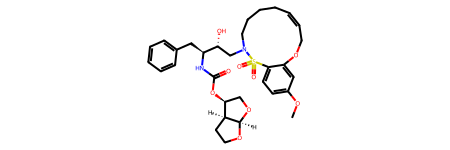

In [68]:
molecules[10]

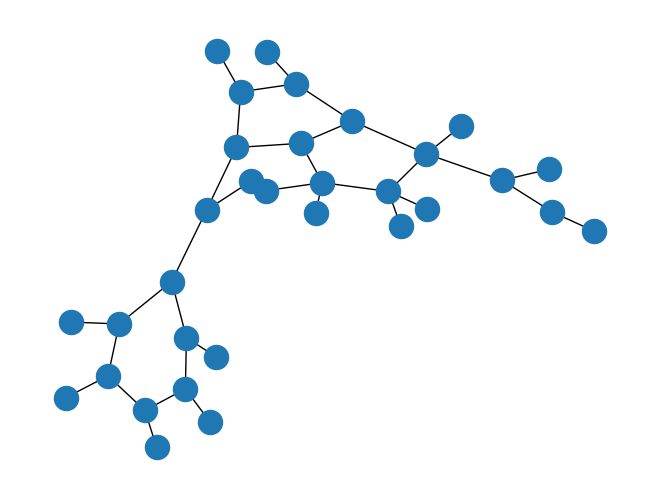

In [17]:
G = rd.read_nx_data_from_file('data.json')[0]

# visualize the molecule using networkx
nx.draw(G)

In [5]:
def predict_mass(atomic_number: int):
    """
    Predict the mass of an atom based on its atomic number.
    """
    return pt.elements[atomic_number].mass

### Convert NetworkX Graph to PyG Data Objects

In [3]:
ONE_HOT_ENC_ATOMIC_NUM = True

data_list = rd.read_pyg_data_from_file('data.json', one_hot_enc_atomic_num=ONE_HOT_ENC_ATOMIC_NUM)

In [20]:
data_loader = DataLoader(data_list, batch_size=1)

### Build Simple MPNN Model

In [38]:
import mpnn as mp

LR = 0.01
BATCH_SIZE = 64
EPOCHS = 100

if ONE_HOT_ENC_ATOMIC_NUM:
    IN_CHANNELS = 123
else:
    IN_CHANNELS = 6

HIDDEN_CHANNELS = 64
OUT_CHANNELS = 3
NUM_LAYERS = 5

In [27]:
# shuffle the data and seed it
seed = 42
np.random.seed(seed)
np.random.shuffle(data_list)

# train_loader = DataLoader(data_list[:int(len(data_list)*0.8)], batch_size=32)
# val_loader = DataLoader(data_list[int(len(data_list)*0.8):int(len(data_list)*0.9)], batch_size=32)
# test_loader = DataLoader(data_list[int(len(data_list)*0.9):], batch_size=32)

train_list = data_list[:int(len(data_list)*0.8)]
val_list = data_list[int(len(data_list)*0.8):int(len(data_list)*0.9)]
test_list = data_list[int(len(data_list)*0.9):]

model = mp.MPNN(in_channels=IN_CHANNELS, hidden_channels=HIDDEN_CHANNELS, out_channels=OUT_CHANNELS, num_layers=NUM_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mp.train_loop(train_list, model, optimizer, num_epochs=20, verbose=True)

Epoch 0, Train Loss: 0.04299402013421059, Val Loss: 0.020053753008445103
Epoch 1, Train Loss: 0.01540523317332069, Val Loss: 0.01260904036462307
Epoch 2, Train Loss: 0.010281760004969935, Val Loss: 0.009228537821521362
Epoch 3, Train Loss: 0.008746461725483339, Val Loss: 0.008888894350578387
Epoch 4, Train Loss: 0.008462147631992897, Val Loss: 0.008305210992693901
Epoch 5, Train Loss: 0.008194257916572193, Val Loss: 0.007833904555688302
Epoch 6, Train Loss: 0.008041069835113983, Val Loss: 0.008450075704604387
Epoch 7, Train Loss: 0.007905162428505719, Val Loss: 0.007915438059717417
Epoch 8, Train Loss: 0.007689013797789812, Val Loss: 0.007062382778773705
Epoch 9, Train Loss: 0.0072938044322654605, Val Loss: 0.007718402799218893
Epoch 10, Train Loss: 0.007591588275196652, Val Loss: 0.0074397220586737
Epoch 11, Train Loss: 0.007167788851074874, Val Loss: 0.007567782544841369
Epoch 12, Train Loss: 0.007088805548846722, Val Loss: 0.0074577671475708485
Epoch 13, Train Loss: 0.00701968114202

In [28]:
train_list[0].y

tensor([[-0.1800,  0.3500,  0.2761],
        [-0.1200,  0.3500,  0.2761],
        [-0.1200,  0.3500,  0.2761],
        [-0.1200,  0.3500,  0.2761],
        [-0.0600,  0.3500,  0.2761],
        [-0.1200,  0.3500,  0.2761],
        [-0.0600,  0.3500,  0.2761],
        [-0.1200,  0.3500,  0.2761],
        [-0.0050,  0.3500,  0.2761],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.2850,  0.2900,  0.5858],
        [ 0.1400,  0.3500,  0.2761],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [-0.1150,  0.3550,  0.2929],
        [ 0.5000,  0.3750,  0.4393],
        [-0.5000,  0.2960,  0.8786],
        [-0.7800,  0.3300,  0.7113],
        [ 0.1400,  0.3500,  0.2761],
 

In [29]:
test_loader = DataLoader(test_list, batch_size=32)
print(test_list[0])
# mp.test_mpnn(test_loader, model)

Data(x=[81, 123], edge_index=[2, 84], edge_attr=[84, 3], y=[81, 3])


In [30]:
mp.test_mpnn(test_loader, model)

0.007144909258931876

In [31]:
def mpnn_predict(data_loader: DataLoader, model):
    model.eval()

    all_predictions = []
    all_true_labels = []
    for data in data_loader:
        with torch.no_grad():
            out = model(data)
        
        all_predictions.append(out)
        all_true_labels.append(data.y)

    # Concatenate predictions and true labels from all batches
    all_predictions = torch.cat(all_predictions, dim=0)
    all_true_labels = torch.cat(all_true_labels, dim=0)
    return all_predictions, all_true_labels

In [32]:
# compare the true values to the predicted values
preds, true_vals = mpnn_predict(test_loader, model)
preds = preds.cpu().numpy()
true_vals = true_vals.cpu().numpy()

In [33]:
pred_charges = preds[:, 0]
true_charges = true_vals[:, 0]

pred_sigma= preds[:, 1]
true_sigma = true_vals[:, 1]

pred_eps = preds[:, 2]
true_eps = true_vals[:, 2]

In [34]:
pred_charges

array([-0.10783849, -0.00859477, -0.0196416 , ...,  0.386494  ,
        0.10423432,  0.11653993], dtype=float32)

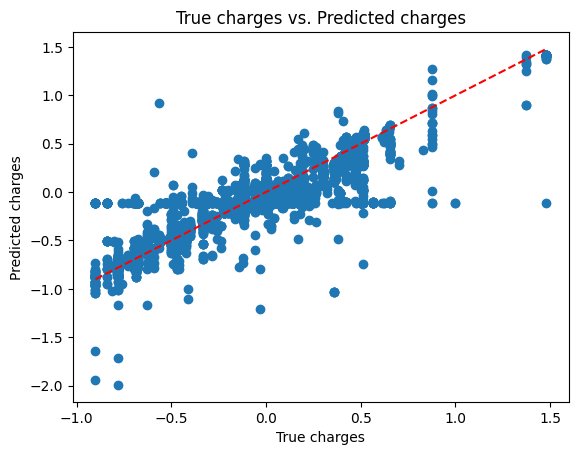

In [35]:
# for the first molecule, plot the true values against the predicted values
import matplotlib.pyplot as plt

plt.scatter(true_charges, pred_charges)
plt.xlabel('True charges')
plt.ylabel('Predicted charges')
plt.title('True charges vs. Predicted charges')

# draw a dashed line to represent the ideal case
max_x = np.max(true_charges)
min_x = np.min(true_charges)

x = np.linspace(min_x, max_x, 100)
y = x

plt.plot(x, y, 'r--')

plt.show()

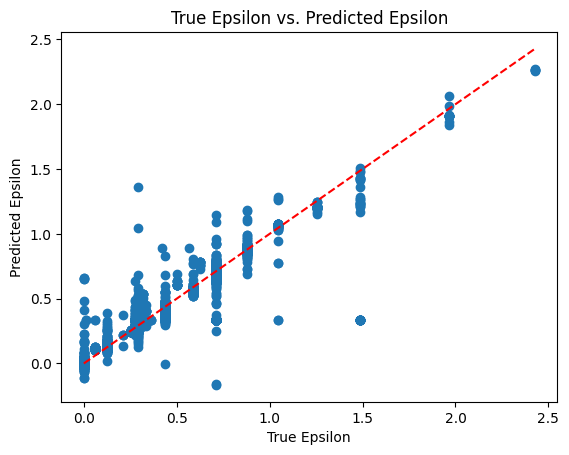

In [36]:
plt.scatter(true_eps, pred_eps)
plt.xlabel('True Epsilon')
plt.ylabel('Predicted Epsilon')
plt.title('True Epsilon vs. Predicted Epsilon')

# draw a dashed line to represent the ideal case
max_x = np.max(true_eps)
min_x = np.min(true_eps)

x = np.linspace(min_x, max_x, 100)
y = x

plt.plot(x, y, 'r--')

plt.show()

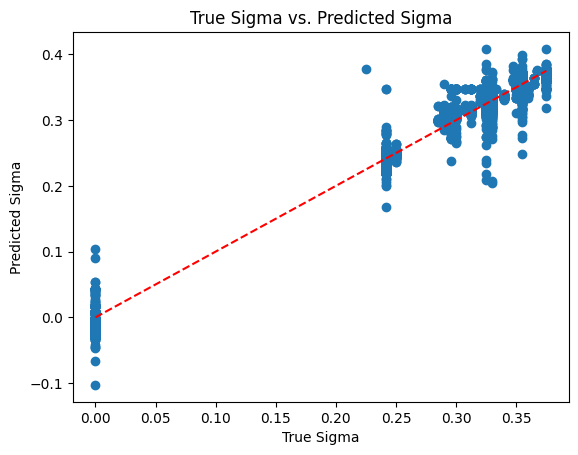

In [37]:
plt.scatter(true_sigma, pred_sigma)
plt.xlabel('True Sigma')
plt.ylabel('Predicted Sigma')
plt.title('True Sigma vs. Predicted Sigma')

# draw a dashed line to represent the ideal case
max_x = np.max(true_sigma)
min_x = np.min(true_sigma)

x = np.linspace(min_x, max_x, 100)
y = x

plt.plot(x, y, 'r--')

plt.show()